In [ ]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""

import arpes.config
arpes.config.DOCS_BUILD = True

# Intermediate Data Manipulation

In [1]:
from arpes.io import example_data

f = example_data.cut

Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2021-07-12_13-35-26.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


## Data rebinning

Frequently it makes sense to integrate in a small region around a single value of interest, or to reduce the size of a dataset uniformly along a particular axis of set of axes. Rebinning the data can be used to accomplish both:

c:\users\chsta\documents\github\arpes\arpes\analysis\general.py:235: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  trimmed_data = data.data[[slices[d] for d in data.dims]]


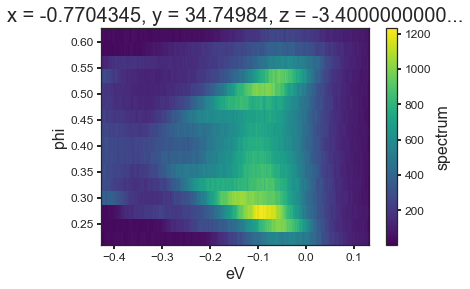

In [15]:
from arpes.analysis.general import rebin

rebin(f, phi=15).S.plot()

Arguments passed into rebin after the first will be matched to dimensions on the input data. In this case, we have requested that every 12 pixels in 'phi' be rebinned into a single pixel. This reduces the size from 240x240 to 240x20. One can also rebin along multiple axes, with different granularities, simultaneously.

## Getting help

Jupyter makes it convenient to get information about language and library functions, you just put a question mark after the function name. We can do this to see what information PyARPES has annotated onto `rebin` in the code

In [19]:
rebin?

Signature:
rebin(
    data: Union[xarray.core.dataarray.DataArray, xarray.core.dataset.Dataset],
    shape: dict = None,
    reduction: Union[int, dict] = None,
    interpolate=False,
    **kwargs,
)
Docstring:
Rebins the data onto a different (smaller) shape.

By default the behavior is to
split the data into chunks that are integrated over. An interpolation option is also
available.

Exactly one of ``shape`` and ``reduction`` should be supplied.

Dimensions corresponding to missing entries in ``shape`` or ``reduction`` will not
be changed.

Args:
    data
    interpolate: Use interpolation instead of integration
    shape: Target shape
    reduction: Factor to reduce each dimension by

Returns:
    The rebinned data.
File:      c:\users\chsta\documents\github\arpes\arpes\analysis\general.py
Type:      function


## Normalizing along an axis

Another common pattern is to normalize data along an axis, so that the total intensity in each frame or slice is equal. This is relatively common in laser-ARPES in combination or as a comparison to normalization by the photocurrent. Another use case is in examining the role of matrix elements in photoemission, or in preparing data to be scaled and plotted on the same axes. `normalize_dim` can be used to normalize along one (second argument `str`) or several (second argument `[str]`) axes:

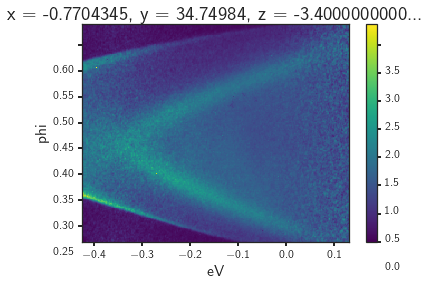

In [24]:
from arpes.preparation import normalize_dim

# make slices equal intensity at every energy
normalize_dim(f.spectrum, "eV").plot()

In this case normalizing along the binding energy axis makes the surface state dispersion from room temperature photoemission off $\text{Bi}_2\text{Se}_3$ for a substantial energy range above the chemical potential.

## Broadcasting

One simple way to achieve background subtraction is to take the mean of the data along a direction known to be a symmetry point, or a point away from dispersive intensity. In general all math operations on `xarray` instances broadcast just as you might expect if you have worked with `numpy`.

In particular, this means that if we create an EDC and subtract it from a spectrum, the EDC will be subtracted from every EDC of the spectrum, uniformly across other axes. We can use this to perform a simple subtraction, here of the EDC at the Gamma point of a $\text{Bi}_2\text{Se}_3$ cut.

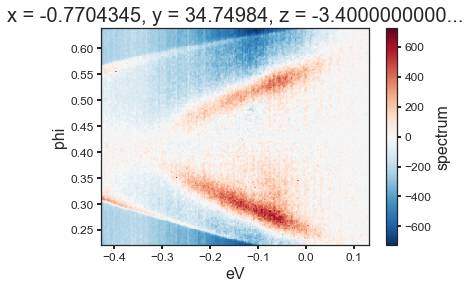

In [25]:
(f - f.sel(phi=slice(0.42, 0.44)).mean("phi")).S.plot()

## Smoothing

There are a number of smoothing facilities included, that are essentially wrappers around those provided in `scipy.ndimage` and `scipy.signal`. More details and other kernels can be found in `arpes.analysis.filters`. Here, we smooth a cut, only along the angular axis, against a Gaussian kernel with a width of 40 mrads.

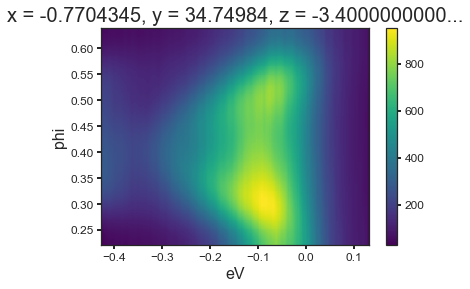

In [26]:
from arpes.analysis.filters import gaussian_filter_arr

gaussian_filter_arr(f.spectrum, sigma={"phi": 0.04}).S.plot()

## Derivatives and Minimum Gradient

Facilities for taking derivatives along specified axes can be found in `arpes.analysis.derivative`. Additionally, the [minimum gradient method](https://arxiv.org/abs/1612.07880) is supported.

Here we illustrate the use of the minimum gradient after smoothing due to small statistics on sample data:

c:\users\chsta\documents\github\arpes\arpes\analysis\derivative.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return arr[slice1] - arr[slice2]


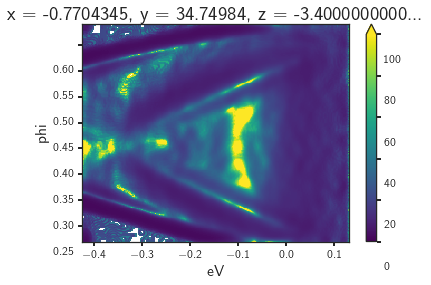

In [27]:
from arpes.analysis.derivative import minimum_gradient

minimum_gradient(gaussian_filter_arr(
    f.spectrum, sigma={"phi": 0.01, "eV": 0.01})).plot(vmin=0, vmax=100)